# Getting Started

## Preparing a radiative transfer object

After installation has finished, let's try to calculate a first spectrum! First we load required external packages though:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Then we'll load pRT by importing:

In [2]:
from petitRADTRANS.radtrans import Radtrans

We also need the physical constants module:

In [3]:
from petitRADTRANS import physical_constants as cst

Let's start out by creating a radiative transfer object using the Radtrans class.

This will create an object ready to calculate spectra once the atmospheric parameters (temperature, abundances, mean molar mass etc.) are set. We will explain the meaning of the function's inputs below.

In [4]:
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Users/molliere/De

First we define the pressure array of the atmosphere. Note that the pressures **must** always be sorted in increasing order, and be equidistant in log-space. The pressure is given to pRT in units of **bar**, although the inernal units in petitRADTRANS are in cgs. Typically we reccommend using around 100 layers in your computations. However, be careful, internally pRT converts the pressure to cgs units!

Next we define the line absorbers to be used for the calculation (``line_species = ...``). 
If you have a fresh pRT installation, your opacity folder will be empty. pRT will automatically download the species which are missing. Here we asked for the following molecular or atomic line absorbers to be inlcuded: ``H2O``, ``CO-NatAbunds`` (all isotopologues at naturally occuring isotope abundances on Earth),  ``CH4``, ``CO2``, ``Na``, and ``K``. Note that there can be different line lists for the same species. You can either load them by adding tags such as ``__HITEMP`` or ``__Allard`` to the absorber names (e.g., ``H2O__HITEMP`` or ``H2O__Exomol``) or by just writing ``H2O`` and setting a default line list, which pRT will store in its configuration file (``.petitradtrans/petitradtrans_config_file.ini`` in your home directory). pRT will do this by automatically asking you the first time you request a species (e.g., ``H2O``) for which multiple options are available. Just choose and pRT will automatically put your selection in ``.petitradtrans/petitradtrans_config_file.ini`` for future use and download the opacity file if necessary. If you do not want to run at pRT's standard resolution for correlated-k opacities ($\lambda/\Delta\lambda = 1,000$) you can reqest another spectral resolution with ``.R300``, so ``H2O.R300``, for example. This will bin down the opacities accordingly, and add them to the input data folder in this new resolution.

Additionally, the Rayleigh scattering cross-sections for ``H2`` and ``He`` were loaded, as well as the collision induced absorption (CIA) cross-sections for the ``H2-H2`` and ``H2-He`` pairs, called ``gas_continuum_contributors`` above.

The wavelength range that was loaded for the opacities here extends from 0.3 to 15 microns.

And we are done! These steps only need to be carried out once, after this we are free to play with this radiative transfer object, for example change the temperature, abundances, etc. Only if additional opacity species need to be loaded is it necessary to create a new Radtrans instance.

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

## Calculating a transmission spectrum

Let's calculate a spectrum for a hot Jupiter, first in transmission. Let's assume an isothermal temperature profile, for now. We start by specifing the temperature array, and abundance dictionery, containing the mass fractions of the atmospheric material, at every layer, and the mean molar masses, at every layer, in units of amu:

In [5]:
temperatures = 1200. * np.ones_like(atmosphere.pressures) # note that pressures is in cgs units now, multiply by 1e-6 to get bars.

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 1e-2 * np.ones_like(temperatures)
mass_fractions['CO2'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['CH4'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['Na'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-6 * np.ones_like(temperatures)

            #  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

**Note that these are freely made up values. The P-T profile of a real planet will likely be different, and not isothermal. Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](poor_man.html) for how to improve this.)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

Next, let's assume a planetary radius and gravity at a given reference pressure bar in the atmosphere, and we are all set!

In [6]:
planet_radius = 1.0*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

Now we simply generate a transmission spectrum. The ``calculate_transit_radii`` returns wavelengths in cm and transit radius in cm, as well as a dictionary of additional optional outputs, which is empty in our example, since we did not request anything in addition.

In [7]:
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

Let's plot the transit radius!

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

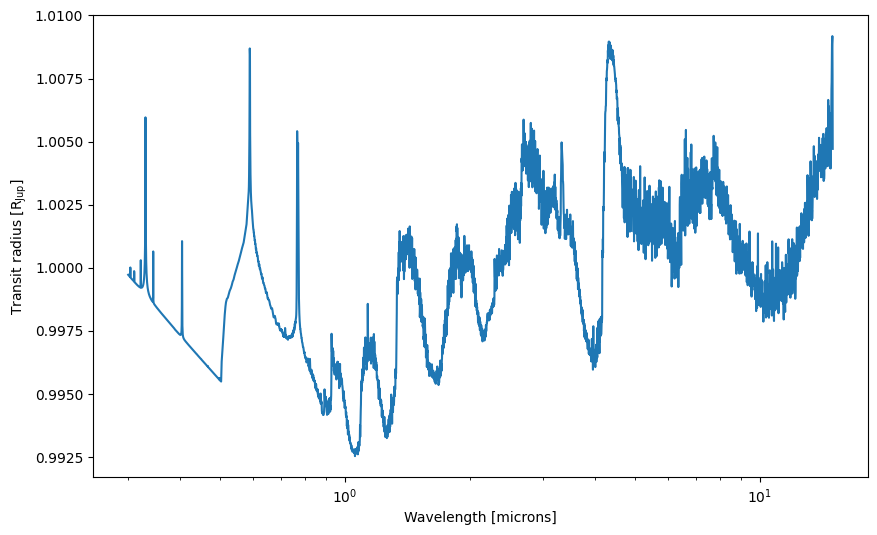

In [8]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, transit_radii/cst.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

## Calculating an emission spectrum

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this). We neglect the scattering here.

</div>

Let's calculate an emission spectrum. Using the isothermal temperature structure from above will simply result in a black body spectrum.
pRT returns all spectra in cgs units at the "surface" (i.e., top of the atmosphere).

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

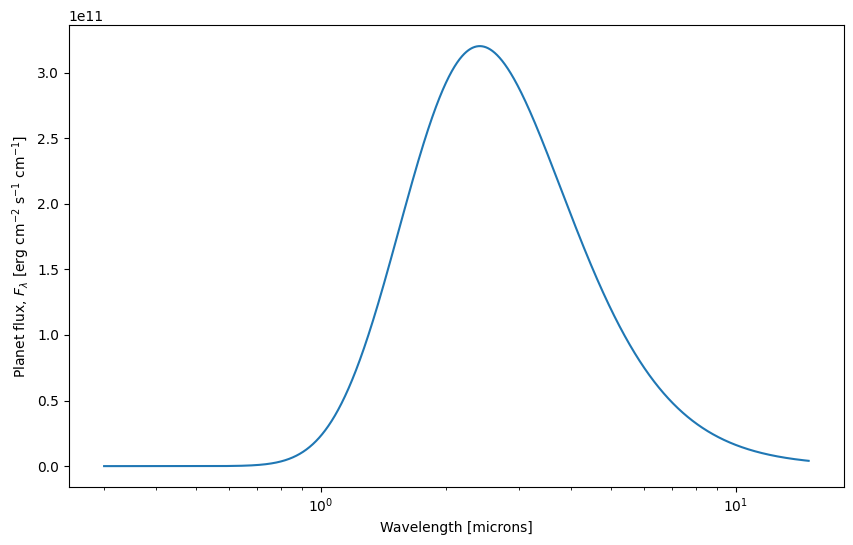

In [9]:
wavelengths, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molar_masses,
                                                 reference_gravity = reference_gravity)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths *1e4, flux)

plt.xscale('log')
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

<div class="alert alert-warning">

**Standard flux units:** before pRT3 flux was accessed as `atmosphere.flux` after running `atmosphere.calc_flux()`, which contained flux as $F_\nu$, so in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$. pRT's `calculate_flux()` method now returns wavelength and flux as $F_\lambda$ in its standard setting, so flux in erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$. To return frequencies and $F_\nu$, instead of wavelengths and $F_\lambda$, please set the keyword `frequencies_to_wavelengths=False` when calling `calculate_flux().`

</div>

Let's try a different temperature structure instead, namely the often-used analytical profile from [Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G), his Equation 29:

\begin{equation}
T^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3T_{\rm equ}^4}{4}\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right]
\end{equation}

with $\tau = P\kappa_{\rm IR}/g$. Here, $\tau$ is the optical depth, $P$ the pressure, $\kappa_{\rm IR}$ is the atmospheric opacity in the IR wavelengths (i.e. the cross-section per unit mass), $\gamma$ is the ratio between the optical and IR opacity, $T_{\rm equ}$ the atmospheric equilibrium temperature, and $T_{\rm int}$ is the planetary internal temperature.

In [10]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global

pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)

Let's plot the P-T profile:

Text(0, 0.5, 'P [bar]')

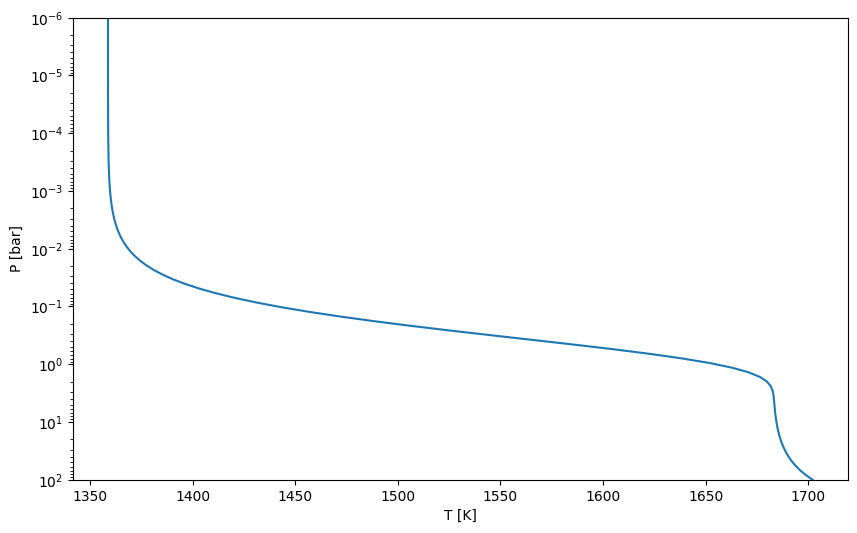

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(temperatures, pressures_bar)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

And recalculate the spectrum:

Text(0, 0.5, 'Planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

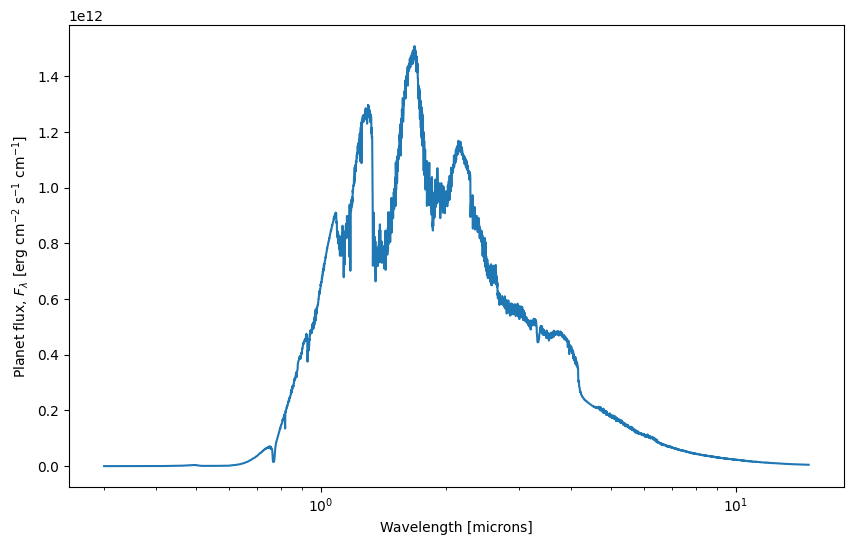

In [12]:
wavelengths, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molar_masses,
                                                 reference_gravity = reference_gravity)
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, flux)

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')